In [1]:
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error as mse

import src.cfg as cfg
import src.data as data
import src.models as models
import src.processing as processing
import src.filters as fltr
from src.viz import Plot

from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 1200
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams["date.autoformatter.year"] = "%Y"
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
mpl.style.use('seaborn-whitegrid')
from mpl_toolkits.basemap import Basemap


Using TensorFlow backend.


In [2]:
parameters = dict(years_train=list(range(2010, 2012)),
                  years_test=[2013],
                  X_vars=['ice_conc','icethic_cea', 'tair'],
                  y_var='hice',
                  bounds=[0, 400, 0, 400],
                  step=[20, 20],
                  dx=5,
                  dy=5,
                  dt=5,
                  n_neurons=20,
                  epochs=70,
                  batch_size=30,
                  loss='mae'
                  )

y_arr_train, X_arr_train = data.load_features(parameters['y_var'],
                                              parameters['X_vars'],
                                              parameters['years_train'])

y_arr_test, X_arr_test = data.load_features(parameters['y_var'],
                                            parameters['X_vars'],
                                            parameters['years_test'])

In [97]:
X_train = np.array(X_arr_train)
y_train = np.array(y_arr_train)

In [98]:
X_train=np.moveaxis(X_train,0,3)

In [99]:
X_train = X_train.reshape(73,10, X_train.shape[1], X_train.shape[2],X_train.shape[3])
y_train = y_train.reshape(73,10, y_train.shape[1], y_train.shape[2],1)

In [115]:
X_train.shape

(73, 10, 452, 406, 3)

In [130]:
input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])
model = Sequential()
model.add(ConvLSTM2D(10,
                      kernel_size=(3,3),
                      padding = "same",
                      return_sequences=True,
                      input_shape=input_shape))
model.add(BatchNormalization())
model.add(ConvLSTM2D(1,
                      kernel_size=(3,3),
                      padding = "same",
                      return_sequences=True))
model.add(BatchNormalization())
model.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
model.compile(loss='binary_crossentropy', optimizer='adadelta')
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_37 (ConvLSTM2D) (None, 10, 452, 406, 10)  4720      
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 452, 406, 10)  40        
_________________________________________________________________
conv_lst_m2d_38 (ConvLSTM2D) (None, 10, 452, 406, 1)   400       
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 452, 406, 1)   4         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 10, 452, 406, 1)   28        
Total params: 5,192
Trainable params: 5,170
Non-trainable params: 22
_________________________________________________________________


In [132]:
h=model.fit(X_train, y_train, batch_size=10, epochs=10, validation_split=0.05)

Train on 69 samples, validate on 4 samples
Epoch 1/10
69/69 [==============================] - 395s 6s/step - loss: nan - val_loss: nan
Epoch 2/10
69/69 [==============================] - 386s 6s/step - loss: nan - val_loss: nan
Epoch 3/10
69/69 [==============================] - 386s 6s/step - loss: nan - val_loss: nan
Epoch 4/10
69/69 [==============================] - 384s 6s/step - loss: nan - val_loss: nan
Epoch 5/10
69/69 [==============================] - 385s 6s/step - loss: nan - val_loss: nan
Epoch 6/10
69/69 [==============================] - 383s 6s/step - loss: nan - val_loss: nan
Epoch 7/10
69/69 [==============================] - 385s 6s/step - loss: nan - val_loss: nan
Epoch 8/10
69/69 [==============================] - 381s 6s/step - loss: nan - val_loss: nan
Epoch 9/10
69/69 [==============================] - 382s 6s/step - loss: nan - val_loss: nan
Epoch 10/10
69/69 [==============================] - 382s 6s/step - loss: nan - val_loss: nan


# model.add(TimeDistributed(Conv2D(output_filters,kernel_size,...), input_shape=(timesteps,x,y,channels))
# model.add(TimeDistributed(MaxPooling2D(...)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(output_dim,...))

In [110]:
X_test = np.array(X_arr_test)
X_test=np.moveaxis(X_test,0,3)
#X_test = X_test.reshape(1,X_test.shape[0], X_test.shape[1], X_test.shape[2],X_test.shape[3])

In [133]:
pred = model.predict(X_test[np.newaxis,:10,::,::,::])

In [134]:
pred.shape

(1, 10, 452, 406, 1)

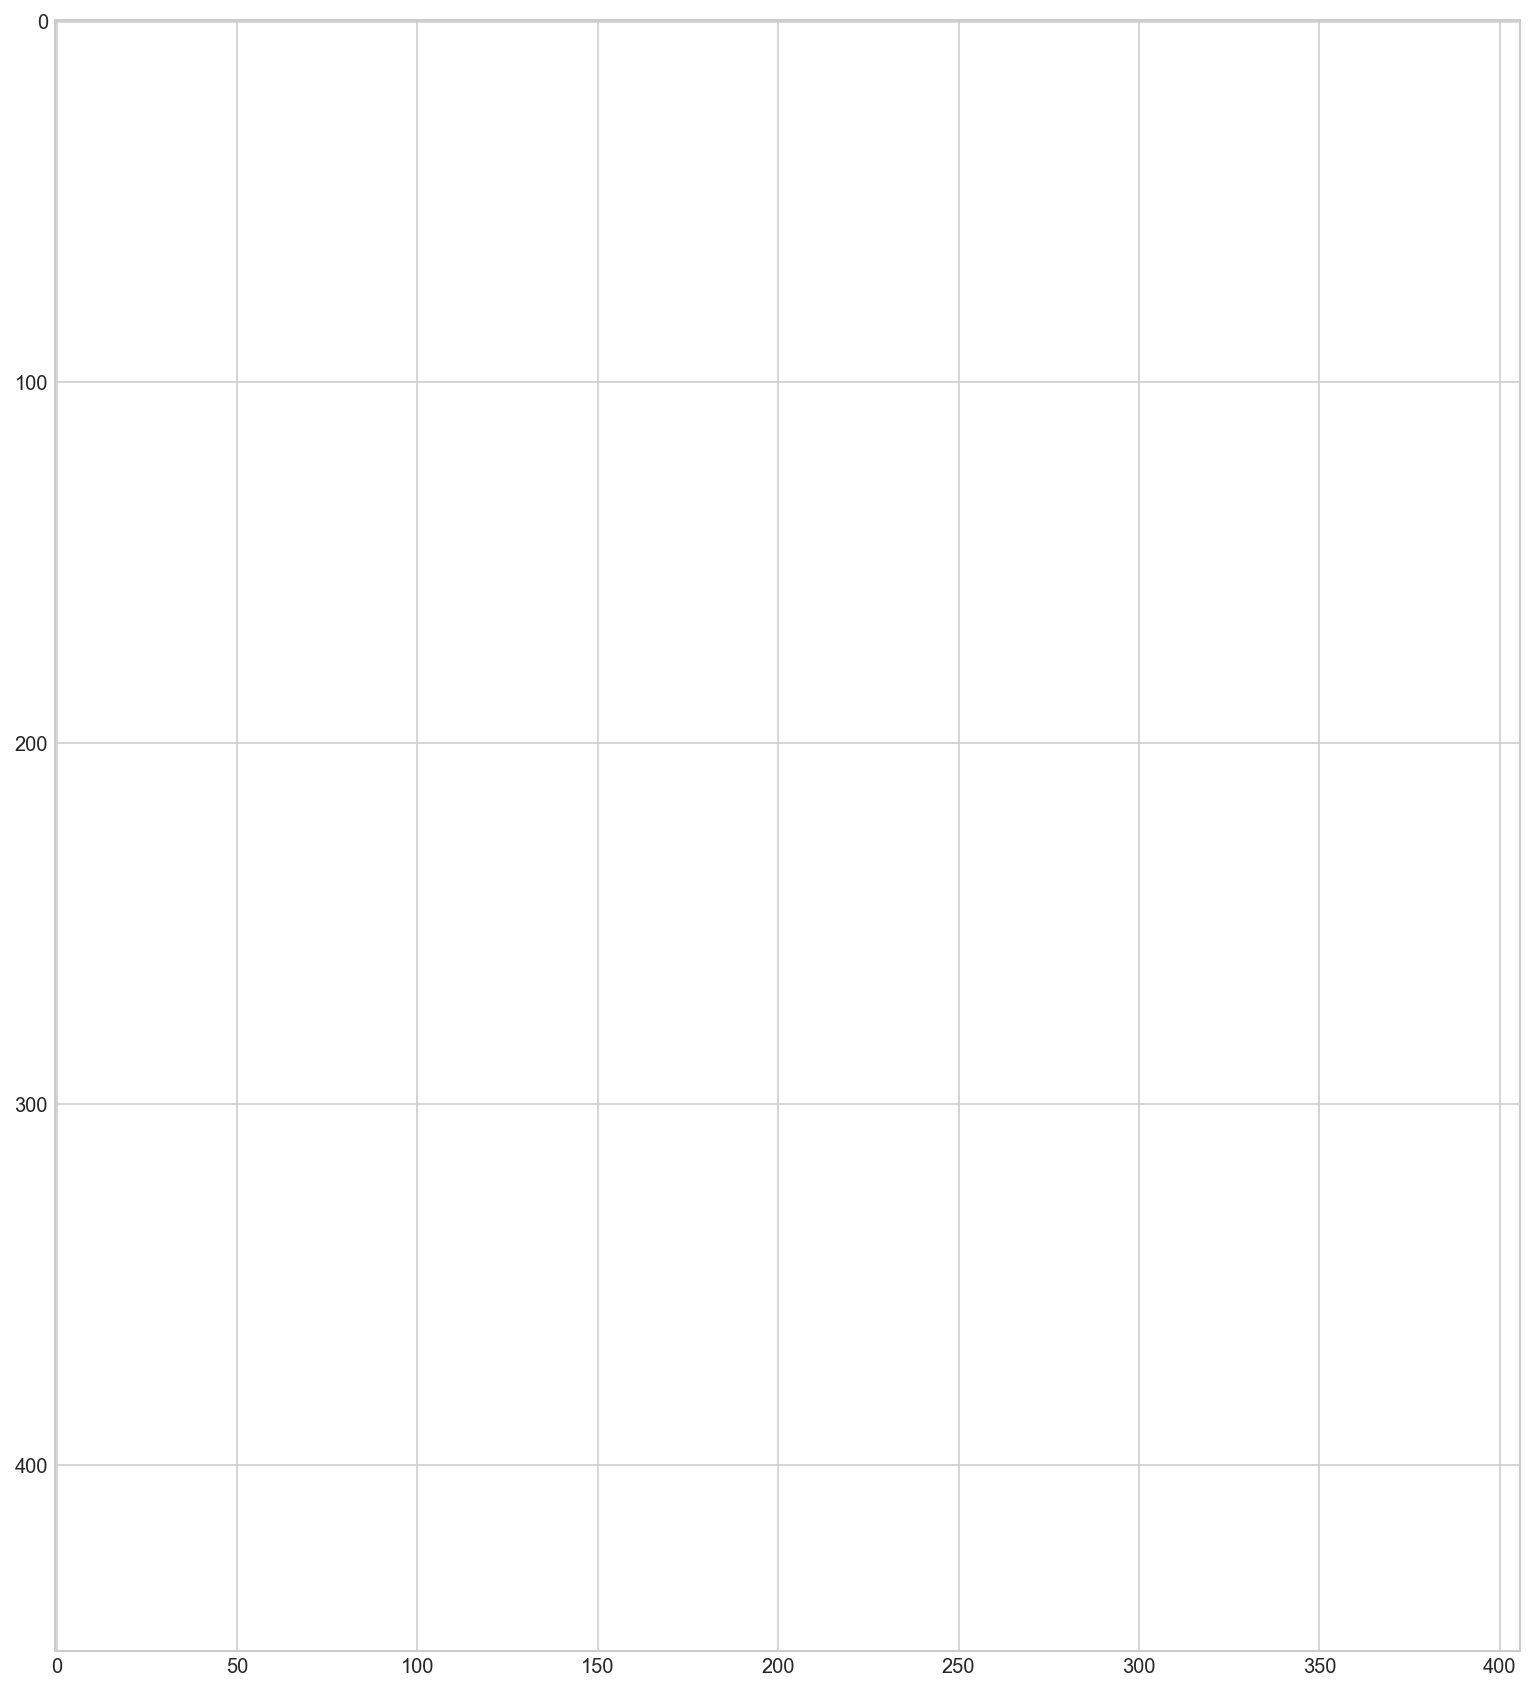

In [135]:
plt.imshow(pred[0,4,:,:,0])

In [125]:
model.history.history

{'loss': [nan]}

In [136]:
np.count_nonzero(~np.isnan(pred))


0